In [1]:
import math
import numpy as np
import re
import string
import cv2
import os
import errno
import random

In [2]:
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
inputWidth = 18
inputHeight = 22


In [3]:
numberLabels = ['0','1','2','3','4','5','6','7','8','9']
numberDictionary = {"image" : [] , "vector": [], "label": []}
letterLabels = []
letterLabels.extend(list(string.ascii_uppercase))
letterDictionary = {"image" : [] , "vector": [], "label": []}

In [ ]:
PATH = "./pictures"
croppedPath = "./cropped"
letterPath = croppedPath + "/letter"
numberPath = croppedPath + "/number"
# labels = !ls "{PATH}"
x0 = 50
y0 = 80
spaceX = 5
spaceFlagX = 105
dy = 170
dx = 95
x1 = x0 + spaceX + dx
x2 = x1 + spaceFlagX + dx
x3 = x2 + spaceX + dx
x4 = x3 + spaceX + dx
n = 0
letterFileNames = []
numberFileNames  = []
for file in os.listdir(PATH):
    if(file.endswith('.png')):
        cropPath = []
        for i in range(4):
            cropPath.append(file[6+i])
        image = cv2.imread(PATH + '/' + file) #converts to grey scale
        grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        crop_img1 = 255 - grayImage[y0:y0+dy, x0:x0+dx]
        #crop_img1 = np.expand_dims(crop_img1, axis=2)
        crop_img2 = 255 - grayImage[y0:y0+dy, x1:x1+dx]
        #crop_img2 = np.expand_dims(crop_img2, axis=2)
        crop_img3 = 255 - grayImage[y0:y0+dy, x2:x2+dx]
        #crop_img3 = np.expand_dims(crop_img3, axis=2)
        crop_img4 = 255 - grayImage[y0:y0+dy, x3:x3+dx]
        #crop_img4 = np.expand_dims(crop_img4, axis=2)
        fileName1 = cropPath[0] + str(n) + '.png'
        fileName2 = cropPath[1] + str(n) + '.png'
        fileName3 = cropPath[2] + str(n) + '.png'
        fileName4 = cropPath[3] + str(n) + '.png'
        letterFileNames.extend([fileName1, fileName2])
        numberFileNames.extend([fileName3, fileName4])
        cv2.imwrite(letterPath +'/'+ fileName1,crop_img1)
        cv2.imwrite(letterPath +'/' + fileName2,crop_img2)
        cv2.imwrite(numberPath +'/' + fileName3,crop_img3)
        cv2.imwrite(numberPath +'/' + fileName4,crop_img4)
        
        n = n+1

In [ ]:
# shuffle data
random.shuffle(letterFileNames)
random.shuffle(numberFileNames)

In [ ]:
# load numbers 
for fileName in numberFileNames:
    pathToImage = numberPath + '/' + fileName
    label = fileName[0]
    index = numberLabels.index(label)
    #creating the vector
    vec = [0] * 36
    vec[index] = 1
    img = cv2.imread(pathToImage)
    img = cv2.resize(img,(inputWidth,inputHeight))
    numberDictionary["image"].append(img/255.0) #normalizing to values between zero and one
    numberDictionary["vector"].append(vec)
    numberDictionary["label"].append(label)

In [ ]:
#load letters
for fileName in letterFileNames:
    pathToImage = letterPath + '/' + fileName
    label = fileName[0]
    index = letterLabels.index(label)
    #creating the vector
    vec = [0] * 36
    vec[index] = 1
    img = cv2.imread(pathToImage)
    img = cv2.resize(img,(inputWidth,inputHeight))
    letterDictionary["image"].append(img/255.0) #normalizing to values between zero and one
    letterDictionary["vector"].append(vec)
    letterDictionary["label"].append(label)

In [6]:
# # train the system

from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend
from keras.preprocessing.image import ImageDataGenerator

def blur(image):
    kernelSize = random.randrange(1, 5+1, 2)
    return cv2.GaussianBlur(image,(kernelSize,kernelSize),cv2.BORDER_DEFAULT)

datagen = ImageDataGenerator(
                              brightness_range=[0.2,1.0],
                               rotation_range = 1,
                               zoom_range = [0.8,1],
                              validation_split = 0.2,
                             width_shift_range = 0.1,
                              height_shift_range = 0.1,
                             shear_range=0.6,
                            preprocessing_function = blur
                            )
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
number_x_train = np.array(numberDictionary["image"])
number_y_train = np.array(numberDictionary["vector"])                   

number_training_generator = datagen.flow(number_x_train,number_y_train,batch_size=64,subset='training')
number_validation_generator = datagen.flow(number_x_train, number_y_train, batch_size=64,subset='validation')

plt.figure(figsize=(10,5))
for i in range(6):
     plt.subplot(2,3,i+1)
     for x,y in number_training_generator:
        plt.imshow((x[0]/255),cmap='gray')
#       plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [ ]:
# set up CNN model for numbers
number_conv_model = models.Sequential()
number_conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(inputHeight,inputWidth, 3)))
number_conv_model.add(layers.MaxPooling2D((2, 2)))
number_conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
number_conv_model.add(layers.MaxPooling2D((2, 2), padding = 'same'))
number_conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
number_conv_model.add(layers.MaxPooling2D((2, 2), padding = 'same'))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2), padding = 'same'))
number_conv_model.add(layers.Flatten())
number_conv_model.add(layers.Dropout(0.5))
number_conv_model.add(layers.Dense(512, activation='relu'))
number_conv_model.add(layers.Dense(36, activation='softmax'))     

number_conv_model.summary()

In [ ]:
LEARNING_RATE = 1e-4
number_conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])


In [ ]:
reset_weights(number_conv_model)
history_conv = number_conv_model.fit_generator(number_training_generator,steps_per_epoch=(len(number_x_train)*0.8)//64, epochs=60, validation_data=number_validation_generator, validation_steps=(len(number_x_train)*0.2)//64)

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
#save the trained model
number_conv_model.save("numberModel.h5")
print("Saved model to disk")


In [18]:
#reload model for further training
from numpy import loadtxt
from keras.models import load_model
 
# load model
number_loaded_model = load_model('numberModel.h5')
# summarize model.
number_loaded_model.summary()
# load dataset

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 16, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 8, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 3, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [19]:
def blurData(grayImage):
    kernelSize = random.randrange(1, 3+1, 2)
    return cv2.GaussianBlur(grayImage,(kernelSize,kernelSize),cv2.BORDER_DEFAULT)

realDataGen = ImageDataGenerator(
                              brightness_range=[0.8,1.0],
                              rotation_range = 10,
                              zoom_range = [0.8,1],
#                               validation_split = 0.2,
#                               width_shift_range = 0.2,
#                              height_shift_range = 0.2,
                             shear_range=0.2,
#                              validation_split = 0.2,
                             preprocessing_function = blurData
    
                            )


In [15]:
# second round of training with real data from the world
numberDataDictionary = {"image" : [] , "vector": [], "label": []}
numberDataPath = "./realData/number"

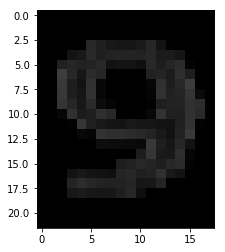

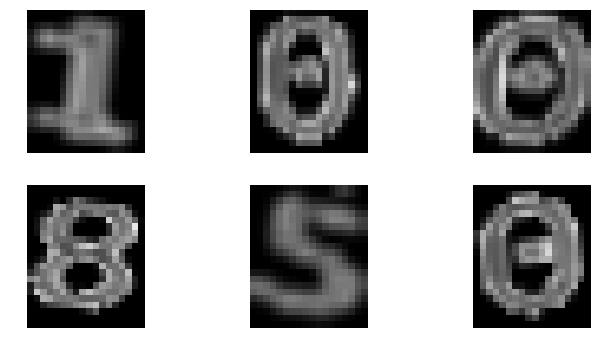

In [16]:
numberDataFiles = []
for file in os.listdir(numberDataPath):
    if(file.endswith('png')):
        numberDataFiles.append(file)
        
random.shuffle(numberDataFiles)
for fileName in numberDataFiles:
    image = cv2.imread(numberDataPath + '/' + fileName)
    image = cv2.resize(image,(inputWidth,inputHeight))
#         print(image.shape)
    grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayImage3 = np.repeat(grayImage[..., np.newaxis], 3, -1)

#         imageBlur = cv2.GaussianBlur(image,(11,11),cv2.BORDER_DEFAULT)
    dataLabel = file[0]
    #creating the vector
    vec = [0] * 36
    index = numberLabels.index(dataLabel)
    vec[index] = 1
#         print(grayImage)
    numberDataDictionary["image"].append(grayImage3/255.0)#?
    numberDataDictionary["vector"].append(vec)
    numberDataDictionary["label"].append(dataLabel)
    plt.imshow(grayImage3)
#         print(grayImage3)
#data augmentation
number_datax_train = np.array(numberDataDictionary["image"])
number_datay_train = np.array(numberDataDictionary["vector"])

data_training_generator = realDataGen.flow(number_datax_train,number_datay_train,batch_size=64)
# validation_generator = realDataGen.flow(datax_train, datay_train, batch_size=64,subset='validation')

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in data_training_generator:
        plt.imshow((x[0]/255),cmap='gray')
#         plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [21]:

loaded_history = number_loaded_model.fit_generator(data_training_generator,steps_per_epoch=(len(number_datax_train)*0.8)//64, epochs=60, validation_data=data_training_generator, validation_steps=(len(number_datax_train)*0.2)//64)

Epoch 1/60


AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

In [ ]:
number_loaded_model.save("numberModel2.h5")
print("Saved model to disk")


In [ ]:
def testModel(img,truth):
  grayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_aug = np.repeat(grayImg[..., np.newaxis], 3, -1)
  img_aug = cv2.resize(img_aug,(inputWidth,inputHeight))
  img_aug = np.expand_dims(img_aug, axis=0)
  y_predict = number_loaded_model.predict(img_aug)[0]
#   print(y_predict)
  plt.imshow(img)
  predictVal = max(y_predict)
#   print(predictVal)
  predictedVal_index = np.where(y_predict == predictVal)[0][0]
  predictedVal = numberLabels[predictedVal_index]
#   groundTruth_index = np.where(datay_train[index] == 1)[0][0]
#   groundTruth = labels[groundTruth_index]
#   print("predicted value:",format(predictedVal))
#   print("ground truth:",format(truth))
  if (predictedVal != truth):
   print("predicted value:",format(predictedVal))
   print("ground truth:",format(truth))


dataPath = "./realData/number"

for file in os.listdir(dataPath):
    if(file.endswith('.png')):
        truth = file[0]
        image = cv2.imread(dataPath + '/' + file) #converts to grey scale
        width, height, dim = image.shape
#         image = cv2.resize(image,(95,170))
        plt.imshow(image)
        testModel(image,truth)